In [40]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
!pip install nltk

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [41]:
data = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/train.csv', encoding='ISO-8859-1')

In [42]:
data.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


<Axes: xlabel='sentiment', ylabel='count'>

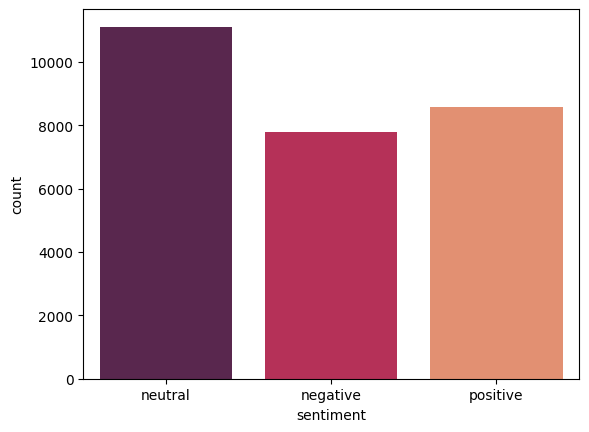

In [43]:
sns.countplot(data,x='sentiment',palette="rocket")

In [44]:
neutral=data[data['sentiment']=="neutral"].head(8500)

In [45]:
data=pd.concat([neutral, data[(data['sentiment'] == 'negative') | (data['sentiment'] == 'positive')]], axis=0)

<Axes: xlabel='sentiment', ylabel='count'>

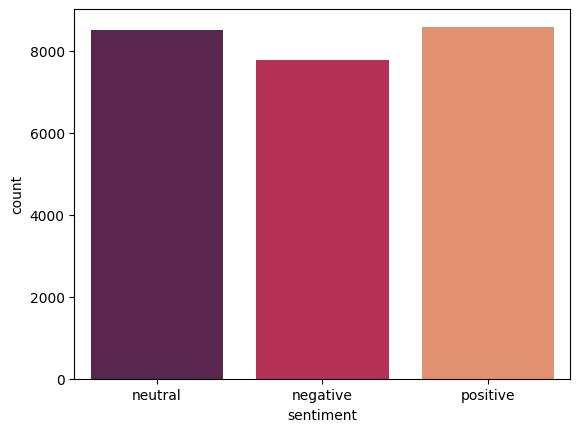

In [46]:
sns.countplot(data,x='sentiment',palette="rocket")

In [47]:
from nltk.stem import PorterStemmer

In [48]:
ps=PorterStemmer()

In [49]:
def stemming(sentence):
    splited_sen=sentence.split(' ')
    splited_stemmed_sen=[ps.stem(word) for word in splited_sen]
    stemmed_sentence = ' '.join(splited_stemmed_sen)
    return stemmed_sentence

In [50]:
data['text'].isna().sum()

1

In [51]:
data=data.dropna(axis=0)

In [52]:
data['text'].isna().sum()

0

In [53]:
stemmed_text=data['text'].apply(stemming)

In [54]:
stemmed_text

0                         i`d have responded, if I were go
5        http://www.dothebouncy.com/smf - some shameles...
7                                               soooo high
8                                              both of you
10        as much as i love to be hopeful, i reckon the...
                               ...                        
27475                                       enjoy ur night
27476     wish we could come see u on denver  husband l...
27477     i`v wonder about rake to.  the client ha made...
27478     yay good for both of you. enjoy the break - y...
27479                            but it wa worth it  ****.
Name: text, Length: 24862, dtype: object

In [55]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [56]:
max_words= 20000

In [57]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(stemmed_text)

In [58]:
sequences = tokenizer.texts_to_sequences(stemmed_text)

In [59]:
max_sequence_length=60

In [60]:
X=pad_sequences(sequences, maxlen=max_sequence_length)

In [61]:
from sklearn.preprocessing import LabelEncoder

In [62]:
le=LabelEncoder()

In [63]:
y=le.fit_transform(data['sentiment'])

In [64]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [65]:
from sklearn.model_selection import train_test_split

In [66]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=.2,shuffle=True,stratify=y)

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, MaxPooling1D, Bidirectional, LSTM, GRU, Dense, Attention

In [96]:
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_sequence_length))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [97]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [98]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [99]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=3,verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',patience=2, verbose=1, restore_best_weights=True)

In [100]:
model.fit(x_train, y_train, 
          epochs=20, 
          batch_size=128, 
          validation_data=(x_test, y_test), 
          callbacks=[lr_scheduler, early_stopping])

Epoch 1/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4318 - loss: 1.0208 - val_accuracy: 0.6875 - val_loss: 0.7203 - learning_rate: 0.0010
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7512 - loss: 0.6193 - val_accuracy: 0.7120 - val_loss: 0.6799 - learning_rate: 0.0010
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8453 - loss: 0.4223 - val_accuracy: 0.6901 - val_loss: 0.7460 - learning_rate: 0.0010
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9081 - loss: 0.2793 - val_accuracy: 0.6905 - val_loss: 0.9260 - learning_rate: 0.0010
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.


In [101]:
y_pred=model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [102]:
from sklearn.metrics import confusion_matrix

<Axes: >

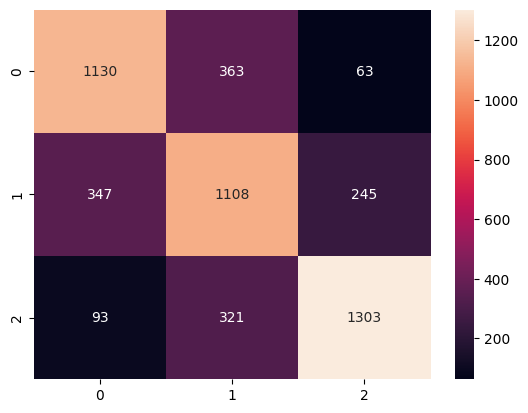

In [103]:
sns.heatmap(confusion_matrix(y_test,y_pred_classes),annot=True,fmt='d')